In [3]:
import csv
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchtext
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import json
import ast
import glob
import re
import string
import collections

In [4]:
patterns = [r'\'', r'\"', r'\.', r'<br \/>', r',', r'\(', r'\)', r'\!', r'\?', r'\:', r'\s+']
replacements = [' \'  ', '', ' . ', ' ', ' , ', ' ( ', ' ) ', ' ! ', ' ? ', ' ', ' ']
patterns_dict = list((re.compile(p), r) for p, r in zip(patterns, replacements))

def basic_english_normalize(line):
    line = line.lower()
    for pattern_re, replaced_str in patterns_dict:
        line = pattern_re.sub(replaced_str, line)
    return line.split()

directions_field = torchtext.data.Field(sequential=True,
                                  tokenize=basic_english_normalize,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True,
                                  init_token="<BOS>",
                                  eos_token="<EOS>")

fields = [('directions', directions_field), ('ingredients', None)]
baseline_data = torchtext.data.TabularDataset("./data/char_nlg_df.csv", "csv", fields)

directions_field.build_vocab(baseline_data)
directions_field.vocab = torchtext.vocab.Vocab(directions_field.vocab.freqs, specials=['<unk>','<pad>', '<BOS>', '<EOS>', ';'])
baseline_vocab_stoi = directions_field.vocab.stoi
baseline_vocab_itos = directions_field.vocab.itos
baseline_vocab_size = len(directions_field.vocab.itos)
print(baseline_vocab_size)
print(directions_field.vocab.itos)

3502
['<unk>', '<pad>', '<BOS>', '<EOS>', ';', 'and', 'in', 'to', 'add', 'with', 'minutes', 'until', 'a', 'mix', 'for', '1', 'the', 'bake', 'at', 'of', 'into', '2', 'on', 'ingredients', 'sugar', 'over', 'or', 'pour', 'stir', 'pan', 'mixture', '350', 'well', 'cook', 'butter', 'cheese', 'heat', 'water', 'together', 'top', 'inch', 'combine', 'salt', 'flour', 'cream', 'all', 'place', 'oven', 'bowl', 'brown', 'cool', 'milk', 'beat', 'baking', 'x', '4', '3', 'chicken', 'eggs', 'cover', 'put', 'onion', 'about', 'dish', 'sprinkle', 'pepper', 'then', 'cup', 'large', '9', 'serve', '10', 'cut', 'greased', 'drain', '30', 'remaining', 'is', 'remove', 'hours', 'boil', 'from', 'sauce', 'let', 'spread', 'hour', 'egg', 'vanilla', '8', '5', 'cake', 'oil', 'makes', 'set', '6', 'hot', '13', '20', 'nuts', '15', 'meat', 'margarine', 'dry', 'simmer', 'roll', 'stirring', 'casserole', 'medium', 'chill', 'each', 'blend', 'soup', 'juice', 'tender', 'pie', 'melt', 'layer', 'potatoes', 'skillet', 'sheet', 'if', 's

----
## Baseline Model

Following code requires torchtext 0.9
It is recommended to run the baseline model seperately. The following code block should be run first before the import code block at the start.

Input data processing:

Model: A generative RNN trained using character-tokenized recipes.

In [5]:
class RNNRecipeGenerator(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers =1 ):
          super(RNNRecipeGenerator, self).__init__()
          self.ident = torch.eye(vocab_size)
          self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first = True)
          self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, inp, hidden = None):
          inp = self.ident[inp]
          output, hidden = self.rnn(inp, hidden)
          output = self.decoder(output)
          return output, hidden

Recipe Generation: Using probability distribution to predict next character. Formatting is done manually corresponding to output from neural network.

In [6]:
def sample_sequence(model, max_len=1000, temperature=0.8):
    generated_sequence = ""
    
    inp = torch.Tensor([baseline_vocab_stoi["<BOS>"]]).long()
    hidden = None
    step = 1

    for c in range(max_len):
          output, hidden = model(inp.unsqueeze(0), hidden)
          output_dist = output.data.view(-1).div(temperature).exp()
          top = int(torch.multinomial(output_dist, 1)[0])

          predicted_char = baseline_vocab_itos[top]

          if predicted_char == "<pad>":
              continue

          if predicted_char == "<BOS>":
              continue
          
          if predicted_char == "<unk>":
              continue

          if predicted_char == ";":
              step += 1
              predicted_char = str("\n " + str(step) + ".")

          if predicted_char == "<EOS>":
              break

          generated_sequence += predicted_char + " "
          inp = torch.Tensor([top]).long()

    return generated_sequence

Training: A sample is printed every print_freq iterations to see the model's progression.

Iteration # 101: Loss 6.470799
Generated Recipe: 
 1. unmolded cube uncovered 
Iteration # 201: Loss 5.574720
Generated Recipe: 
 1. steamed muffin community wings as piece pour pudding sherbet over brown cavity container add tatar a chopped fat even will shells crescent meringue sprinkle cook 4 golf mix a hour uncooked golden mix garlic paraffin next melted a pour broccoli prepared till aside wedges toss goes until jell 450 for coarse 
Iteration # 301: Loss 5.518228
Generated Recipe: 
 1. gas just prune to casserole dough skillet do shake well 55 bake 
Iteration # 401: Loss 5.445486
Generated Recipe: 
 1. tostados cups kiwi 7 seasoning put mix basting bagels little dressing dressing tomato nuts with until cool well minute heat powdered cook ingredients with add under mixer well sheets of 2 375 whiz evenly down 3 are drained against desired then serve remaining reused mixture ball baking place butter marshmallows cover store 
Iteration # 501: Loss 4.375738
Generated Recipe: 
 1. bowl a

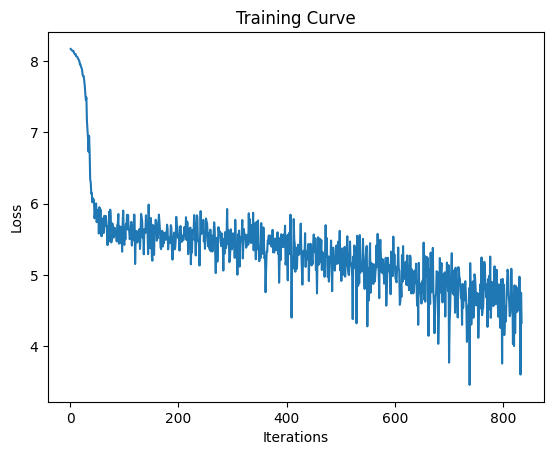

In [7]:
def train_baseline(model, data, batch_size=1, num_epochs=1, lr=1e-3, print_freq=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    iter = 0
    data_iter = torchtext.data.BucketIterator(data, batch_size=batch_size, sort_key=lambda x: len(x.directions), sort_within_batch=True)
    losses, iterations = [],[]

    for e in range(num_epochs):
        avg_loss = 0
        min_loss = float('inf')
        for (directions, lengths), ingredients in data_iter:
            target = directions[:, 1:]
            inp = directions[:, :-1]

            optimizer.zero_grad()

            output, _ = model(inp)
            loss = criterion(output.reshape(-1, baseline_vocab_size), target.reshape(-1))

            loss.backward()
            optimizer.step()

            avg_loss += loss
            iter += 1
            losses.append(float(loss))
            iterations.append(iter)

            if iter % print_freq == 0:
                  print("Iteration # %d: Loss %f" % (iter+1, float(avg_loss/print_freq)))
                  print("Generated Recipe: \n 1. " + sample_sequence(model, 1000, 1.5))
                  avg_loss = 0


    plt.title("Training Curve")
    plt.plot(iterations, losses, label = "Training")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

baseline_model = RNNRecipeGenerator(baseline_vocab_size, 64, n_layers=1)
train_baseline(baseline_model, baseline_data, batch_size=12, num_epochs=2, lr=1e-3, print_freq=100)